In [997]:
#import autograd.numpy as np  # Thinly-wrapped numpy
#from autograd import grad
#from autograd import hessian
import numpy as np
from scipy.optimize import minimize,Bounds,LinearConstraint,NonlinearConstraint
import matplotlib.pyplot as pl
import copy
from sklearn.metrics.pairwise import euclidean_distances

In [2206]:
random_x=np.random.uniform(21,37,50).reshape((-1,1))
random_y=np.random.uniform(21,37,50).reshape((-1,1))
obs_np=np.concatenate([random_x,random_y],axis=1)

In [2207]:
def J_vehicle(x_c):
    ret_array=np.array([[np.cos(x_c[-1]),0.],[np.sin(x_c[-1]),0.],[0.,1.]])
    return(ret_array)

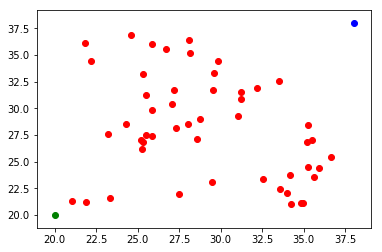

In [2208]:
start_point=np.array([38.,38.,-2.])
end_point=np.array([20.,20.])
pl.scatter(random_x,random_y,c='r')
pl.scatter(start_point[0],start_point[1],c='b')
pl.scatter(end_point[0],end_point[1],c='g')

In [2209]:
def rollout_sc(control,start,ts=0.1,th=50):
    cur_state=copy.copy(start)
    points_list=[]
    for i in range(th):
        J=J_vehicle(cur_state)
        x_dot=np.matmul(J,control)
        cur_state+=x_dot*ts
        points_list.append(copy.copy(cur_state))
    return(np.array(points_list))   


In [2210]:
control=np.array([1.,-0.1])
points_np=rollout_sc(control,start_point)

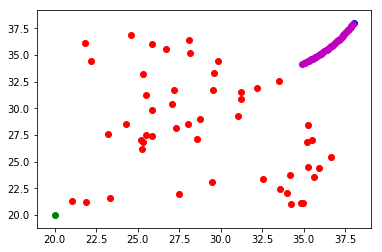

In [2211]:
pl.scatter(random_x,random_y,c='r')
pl.scatter(start_point[0],start_point[1],c='b')
pl.scatter(end_point[0],end_point[1],c='g')
pl.scatter(points_np[:,0],points_np[:,1],c='m')

In [2212]:
steps=np.arange(-3.1,3.1,0.05)

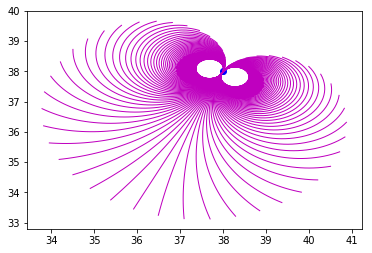

In [2300]:
#holding controls
for i in range(len(steps)):
    control=np.array([1.,steps[i]])
    points_np=rollout_sc(control,start_point)
    pl.plot(points_np[:,0],points_np[:,1],c='m',lw=1)
pl.scatter(start_point[0],start_point[1],c='b')
#pl.scatter(end_point[0],end_point[1],c='g')
#pl.scatter(random_x,random_y,c='r')

In [2214]:
control=np.array([0.,0.])
points_np=rollout_sc(control,start_point)

In [2215]:
def ttc_rollout(control,start,ts=0.1,th=50):
    cur_state=copy.copy(start)
    count=0.0
    dist_sum=0.0
    for i in range(th):
        J=J_vehicle(cur_state)
        x_dot=np.matmul(J,control)
        cur_state+=x_dot*ts
        count+=1.0
        d_cost=np.linalg.norm(cur_state[:2]-end_point)
        #dist_sum+=d_cost
        dist=np.linalg.norm(cur_state[:2]-obs_np,axis=1)
        if((np.min(dist)<0.5)):
            #cost=(dist_sum/count)+(50./((count*ts)))
            cost=d_cost+(50./((count*ts)**2))
            return(cost)
    #cost=(dist_sum/count)#+(5./((count*ts)))
    cost=d_cost
    return(cost)

def rollout(x_dot,cur_point,ts=0.1,th=50):
    x_c=copy.copy(cur_point)
    x_dot_r=x_dot.reshape(-1)
    cost_v=0.0
    for i in range(0,th):
        jac_v=J_vehicle(x_c)
        nextstep=np.matmul(jac_v,x_dot_r)*ts
        x_c=x_c+nextstep
        norm_dist=np.linalg.norm(x_c[:2]-end_point)
        obs_ratio=15./(ts*(i+1)*(np.min(np.linalg.norm(x_c[:2]-obs_np,axis=1))))
        #obs_ratio=np.max((1./(2.5*sigma))*(np.exp(-0.5*(np.linalg.norm(x_c[:2]-obs_np,axis=1)/sigma)**2)))
        #obs_ratio=np.max(np.exp(-(np.linalg.norm(x_c[:2]-obs_np,axis=1))**2))
        if(norm_dist<0.1):
            return(cost_v)
        cost_v=cost_v+(norm_dist)+(obs_ratio)
    return(cost_v)


In [2216]:
%%time
ttc_rollout(control,start_point)

CPU times: user 12.7 ms, sys: 710 µs, total: 13.4 ms
Wall time: 9.91 ms


25.45584412271571

In [2217]:
%%time
rollout(control,start_point)

CPU times: user 17.4 ms, sys: 188 µs, total: 17.6 ms
Wall time: 13.9 ms


1368.6100137095987

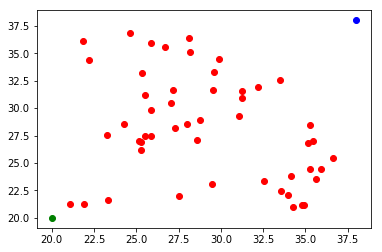

In [2218]:
pl.scatter(points_np[:,0],points_np[:,1],c='m',s=4)
pl.scatter(start_point[0],start_point[1],c='b')
pl.scatter(end_point[0],end_point[1],c='g')
pl.scatter(random_x,random_y,c='r')

In [2255]:
single_con=np.array([1.5, 0.])
ubounds=np.array([1.5,1.])
lbounds=np.array([0.,-1.])
ubounds=ubounds.reshape(-1)
lbounds=lbounds.reshape(-1)
LinBounds=Bounds(lbounds,ubounds)
#A_b=np.eye(2)
#LinBounds=LinearConstraint(A_b,lbounds,ubounds)

In [2280]:
#start_point=np.array([27.,36.5,-2.5])
start_point=np.array([35.,35.,-1.5])
end_point=np.array([20.,20.])

In [2304]:
%%time
res=minimize(ttc_rollout,single_con,method='slsqp',args=(start_point),bounds=LinBounds,options={'ftol':0.5})

CPU times: user 69.9 ms, sys: 787 µs, total: 70.7 ms
Wall time: 66.9 ms


In [2305]:
%%time
res=minimize(rollout,single_con,method='slsqp',args=(start_point),bounds=LinBounds,options={'ftol':0.5})

CPU times: user 60.4 ms, sys: 3.38 ms, total: 63.8 ms
Wall time: 57.1 ms


In [2306]:
res.x

array([1.5       , 0.03944843])

In [2307]:
pos=rollout_sc(res.x,start_point)

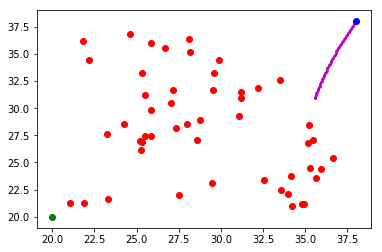

In [2308]:
pl.scatter(pos[:,0],pos[:,1],c='m',s=4)
pl.scatter(start_point[0],start_point[1],c='b')
pl.scatter(end_point[0],end_point[1],c='g')
pl.scatter(random_x,random_y,c='r')
#pl.xlim([24,34])
#pl.ylim([24,34])

In [2309]:
def integrate_next_step(x_0,x_dot,ts_c=0.1):
    x_c=copy.copy(x_0)
    jac_v=J_vehicle(x_c)
    x_c+=np.matmul(jac_v,x_dot)*ts_c    
    return(x_c)

In [2313]:
%%time
start_point=np.array([38.,38.,-2.])
end_point=np.array([20.,20.])
cur_point=copy.copy(start_point)
pos_list=[]
vel_list=[]
cur_con=copy.copy(single_con)
for i in range(0,200):
    pos_list.append(copy.copy(cur_point))
    res=minimize(rollout,cur_con,method='slsqp',args=(cur_point),bounds=LinBounds,options={'ftol':0.1})
    cur_con=copy.copy(res.x)
    next_point=integrate_next_step(cur_point,cur_con)
    cur_point=next_point
    vel_list.append(cur_con)
    if(np.linalg.norm(cur_point[:2]-end_point)<0.1):
        break

CPU times: user 2.62 s, sys: 0 ns, total: 2.62 s
Wall time: 2.62 s


In [2314]:
pos_np=np.array(pos_list)
vel_np=np.array(vel_list)

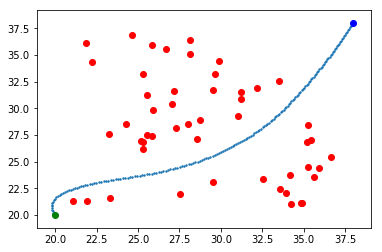

In [2315]:
pl.scatter(pos_np[:,0],pos_np[:,1],s=2)
pl.scatter(random_x,random_y,c='r')
pl.scatter(start_point[0],start_point[1],c='b')
pl.scatter(end_point[0],end_point[1],c='g')

In [2299]:
%%time
ttc_rollout(cont,start_point)

CPU times: user 16.2 ms, sys: 624 µs, total: 16.9 ms
Wall time: 5.33 ms


20.399420591978995

In [1935]:
def ttc_checkCol(control,start,ts=0.1,th=40):
    cur_state=copy.copy(start)
    count=0.0
    dist_sum=0.0
    for i in range(th):
        J=J_vehicle(cur_state)
        x_dot=np.matmul(J,control)
        cur_state+=x_dot*ts
        dist=np.linalg.norm(cur_state[:2]-obs_np,axis=1)
        if((np.min(dist)<1.)):
            return(i*ts)
    return(th*ts) 

In [1936]:
ttc_checkCol(res.x,start_point)

4.0